## My first neural network    

This program creates a 3-layer backpropagation neural network capable of recognizing handwritten digits, able to reach almost 98 % accuracy.

It is compatible with the MNIST data set, which uses an inverse color scale (white is 0 and black is 255), and greyscale images that are 28x28 pixels in size. For it to be compatible with standard images they must be color-inverted and resized to 28x28. User generated images can be analyzed after it has been trained, but they must also be uploaded as 28x28 PNGs.

The MNIST training data set is ~60,000 images large. Depending on the number of hidden nodes, epochs, and whether the rotated image versions are included (upping the dataset to 180,000 images), it will take a couple minutes for the neural network to be trained.

The MNIST data can be downloaded in CSV format from http://www.pjreddie.com/media/files/mnist_train.csv and http://www.pjreddie.com/media/files/mnist_test.csv.

In [5]:
import numpy as np
import scipy.special
import scipy.ndimage
import imageio
import glob
import matplotlib.pyplot as pyplot
%matplotlib inline

In [56]:
######################################################################
# NeuralNetwork class for a 3-layer backpropagation neural network.  #
# Has functionality to be trained on the MNIST dataset, and can then #
# take user generated input (that is 28x28 pixels)                   #
######################################################################
class NeuralNetwork:
    
    def __init__(self, inputNodes, hiddenNodes, outputNodes, learningRate):
        # set the number of nodes
        self.inputNodes = inputNodes
        self.hiddenNodes = hiddenNodes
        self.outputNodes = outputNodes
        
        # set the learning rate
        self.learningRate = learningRate
        
        # initialize weight matrices weightIH and weightHO
        # weights inside the arrays are w_ij, where link is from
        # node i to node j in the next layer
        self.weightsIH = np.random.normal(0.0, pow(self.inputNodes, -0.5),
                                         (self.hiddenNodes, self.inputNodes))
        self.weightsHO = np.random.normal(0.0, pow(self.hiddenNodes, -0.5),
                                         (self.outputNodes, self.hiddenNodes))
        
        # the activation function is a sigmoid
        self.activationFunction = lambda x: scipy.special.expit(x)
        
    
    # train the NN
    def train(self, inputsList, targetsList):
        # convert inputsList to 2D array - inputsList is a list
        inputs = np.array(inputsList, ndmin = 2).T
        targets = np.array(targetsList, ndmin = 2).T
        
        # calculate signals into hidden layer
        hiddenInputs = np.dot(self.weightsIH, inputs)
        # calculate signals exiting hidden layer
        hiddenOutputs = self.activationFunction(hiddenInputs)
        
        # calculate signals into final layer
        finalInputs = np.dot(self.weightsHO, hiddenOutputs)
        # calculate signals exiting final layer
        finalOutputs = self.activationFunction(finalInputs)
        
        # the output layer error is the target minus the actual output
        outputErrors = targets - finalOutputs
        
        # the hidden layer error is the outputErrors, split by weights,
        # recombined at the hidden nodes
        hiddenErrors = np.dot(self.weightsHO.T, outputErrors)
        
        # update the weights for the links between the hidden and output layers
        self.weightsHO += self.learningRate * np.dot((outputErrors * finalOutputs * (1.0 - finalOutputs)),
                                                     np.transpose(hiddenOutputs))
        # update the weights for the links between the input and hidden layers
        self.weightsIH += self.learningRate * np.dot((hiddenErrors * hiddenOutputs * (1.0 - hiddenOutputs)),
                                                     np.transpose(inputs))
  
    
    # query the NN
    def query(self, inputsList):
        # convert inputsList to 2D array
        inputs = np.array(inputsList, ndmin = 2).T
        
        # calculate inputs to hidden layer
        hiddenInputs = np.dot(self.weightsIH, inputs)
        # calculate outputs from hidden layer
        hiddenOutputs = self.activationFunction(hiddenInputs)
        
        # calculate inputs to final layer
        finalInputs = np.dot(self.weightsHO, hiddenOutputs)
        # calculate the final outputs
        finalOutputs = self.activationFunction(finalInputs)
        
        return finalOutputs
    
    
    # train the NN on all the MNIST data, with the option to include every image rotated +/- 10 deg
    def trainOnMnistData(self, epochs, includeRotated):
        print("Please wait while I am being trained...")
        
        if (self.inputNodes != 784 or self.outputNodes != 10):
            print("Neural network has the incorrect number of input or output nodes to function on the MNIST dataset.\n")
        
        # load the MNIST training data CSV file into a list
        trainingDataFile = open("MNIST dataset/mnist_train.csv", 'r')
        trainingDataList = trainingDataFile.readlines()
        trainingDataFile.close()

        # train the neural network!
        # the epochs is the number of times the training data set is used for training
        for e in range(epochs):
            # iterate over all the records in the trainingDataList
            for record in trainingDataList:
                allValues = record.split(',')
                # normalize every input to the range 0.01 to 1.0
                inputs = getScaledInputs(allValues)
                # create target matrix where the value at the index of the label is 0.99, rest is 0.01
                targets = np.zeros(outputNodes) + 0.01
                targets[int(allValues[0])] = 0.99
                self.train(inputs, targets)
                
                # if includeRotated is True, train the NN on every image rotated +/- 10 deg, too
                if (includeRotated):
                    self.trainOnRotatedImages(inputs, targets)
        
        print("My training is done.\n")
        
    
    def trainOnRotatedImages(self, inputs, targets):
        # create rotated variations for extra training
        img = inputs.reshape(28,28)
        # rotated anticlockwise by 10 degrees
        inputsPlus10Img = scipy.ndimage.interpolation.rotate(img, 10, cval = 0.01, order = 1, reshape = False)
        self.train(inputsPlus10Img.reshape(784), targets)
        # rotated clockwise by x degrees
        inputsMinus10Img = scipy.ndimage.interpolation.rotate(img, -10, cval = 0.01, order = 1, reshape = False)
        self.train(inputsMinus10Img.reshape(784), targets)
                
            
    # test the NN vs the MNIST test data and output its performance
    def testOnMnistData(self):
        #load the MNIST test data CSV file into a list
        testDataFile = open("MNIST dataset/mnist_test.csv", 'r')
        testDataList = testDataFile.readlines()
        testDataFile.close() 

        # test the neural network
        # first, keep track of the "score"
        scorecard = []

        # go through all the records in the test data set
        for record in testDataList:
            allValues = record.split(',')

            # get the correct answer - it is the first character in the dataset
            correctLabel = int(allValues[0])

            # scale the inputs
            inputs = getScaledInputs(allValues)

            # query the network
            outputs = self.query(inputs)

            # the determined label is the index of the highest value in outputs
            label = np.argmax(outputs)

            # update scorecard
            if (label == correctLabel):
                scorecard.append(1)
            else:
                scorecard.append(0)

        scorecardArray = np.asarray(scorecard)
        print("I can correctly identify %.2f" % (scorecardArray.sum() / scorecardArray.size * 100), "% of handwritten digits\n")
        
        
    def testOnOwnData(self, data, item):
        # plot the image
        pyplot.imshow(data[item][1:].reshape(28,28), cmap = 'Greys', interpolation = 'None')

        # correct answer is the first value in the record
        correctLabel = data[item][0]
        # actual data is the remaining values
        inputs = data[item][1:]

        # query the network
        outputs = self.query(inputs)
        print ("\nThe network output is:\n")
        printOutputTable(outputs)

        # the index of the highest value corresponds to the label
        label = np.argmax(outputs)
        print("\nThe network says", label)
        # append correct or incorrect to list
        if (label == correctLabel):
            print ("It's a match!")
        else:
            print ("No match...")

    
##################################################################################
# Other helper methods that are not instance methods for the NeuralNetwork class #
##################################################################################

def getScaledInputs(allValues):
    return (np.asfarray(allValues[1:]) / 255.0 * 0.99) + 0.01


def getMyOwnImageData():
    myOwnDataset = []

    # load the png image data as test data set
    for imageFileName in glob.glob('Handdrawn data/?.png'):

        # use the filename to set the correct label - it is the 5th character from the end
        label = int(imageFileName[-5:-4])

        # load image data from png files into an array
        print ("loading ...", imageFileName)
        imgArray = imageio.imread(imageFileName, as_gray = True)

        # reshape from 28x28 to list of 784 values, and invert values
        imgData  = 255.0 - imgArray.reshape(784)

        # then scale data to range from 0.01 to 1.0
        imgData = (imgData / 255.0 * 0.99) + 0.01

        # append label and image data to test data set
        record = np.append(label, imgData)
        myOwnDataset.append(record)
        
    return myOwnDataset

# Method to nicely format the output from the NN
def printOutputTable(array):
    # Do heading
    print("        ", end = "")
    for i in range(len(array)):
        print("%5d " % i, end = "")
    print()
    print("          ", end = "")
    for i in range(len(array)):
        print("------", end = "")
    print()
    # Matrix contents
    print("%3s |" % ("Matching"), end = "") # Row nums
    for i in range(len(array)):
        print("%5.2f " % float((array[i])), end = "")
    print()

Let's test the neural network below, using 200 hidden nodes, a learning rate of 0.05 and just 1 epoch.

Please wait while I am being trained...
My training is done.

I can correctly identify 96.13 % of handwritten digits

loading ... Handdrawn data\2.png
loading ... Handdrawn data\3.png
loading ... Handdrawn data\5.png
loading ... Handdrawn data\6.png

The network output is:

            0     1     2     3     4     5     6     7     8     9 
          ------------------------------------------------------------
Matching | 0.00  0.04  0.97  0.02  0.00  0.00  0.02  0.00  0.01  0.00 
The network says 2
It's a match!


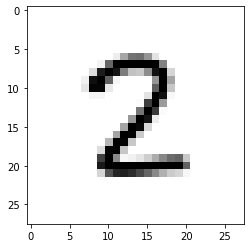

In [57]:
# number of input, hidden and output nodes
inputNodes = 784
hiddenNodes = 200
outputNodes = 10
# learning rate is 0.05
learningRate = 0.05

# Create an instance of NeuralNetwork
myNeuralNetwork = NeuralNetwork(inputNodes, hiddenNodes, outputNodes, learningRate)

# Train the NN using 1 epoch, and including the rotated versions of each image
epochs = 1
includeRotated = True
myNeuralNetwork.trainOnMnistData(epochs, includeRotated)

# Test its performance
myNeuralNetwork.testOnMnistData()

# Prepare the user generated images
data = getMyOwnImageData()
# The item to test is the first in this example, so index 0
item = 0

# Try it out!
myNeuralNetwork.testOnOwnData(data, item)